# Setup Empty Pipeline with Screen


In [1]:
# import resources
from zipline.pipeline import Pipeline
from zipline.pipeline.factors.basic import SimpleMovingAverage
from zipline.pipeline.data import USEquityPricing

# Create a screen for our Pipeline
mean_close_10 = SimpleMovingAverage(
    inputs=[USEquityPricing.close],
    window_length=10
)

universe = mean_close_10 > 10

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen=universe)

# Setup Zipline Engine

In [3]:
import helper
from zipline.utils.calendars import get_calendar
from zipline.data import bundles

# Name of bundle
EOD_BUNDLE_NAME = 'quantopian-quandl'

# Load the data bundle
bundle_data = bundles.load(EOD_BUNDLE_NAME)

# Setup the engine to look at the top 500 stocks who have had the highest rolling Average Dollar Volume
# over a 120-day window -- This is arbitrary and we can use this parameter to refine which stocks we
# want in our universe
universe = mean_close_10.top(500) 

# Select the trading calendar that will be used as a reference when slicing the data
trading_calendar = get_calendar('NYSE') 

# Load the bundle we configured in the previous step into the engine
bundle_data = bundles.load(EOD_BUNDLE_NAME)

# Create the engine -- the details of this function are in the utils.py file
engine = helper.build_pipeline_engine(bundle_data, trading_calendar)

# View Pipeline as Graph

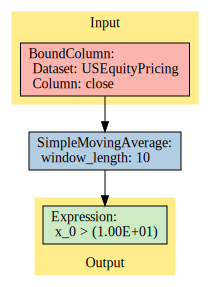

In [3]:
import graphviz

# Render the pipeline as a DAG
pipeline.show_graph()

# Run Pipeline Engine

In [5]:
import pandas as pd

# Set the start and end dates
start_date = pd.Timestamp('2017-01-05', tz = 'utc')
end_date = pd.Timestamp('2017-01-05', tz = 'utc')

# Run our pipeline for the given start and end dates
pipeline_output = engine.run_pipeline(pipeline, start_date, end_date)

# Get Universe Tickers

In [6]:
# Get the values in index level 1 and save them to a list
universe_tickers = pipeline_output.index.get_level_values(1).values.tolist()

# Create Data Portal

In [7]:
from zipline.data.data_portal import DataPortal

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

# View Historical Data

Get the OHLC + V data for a given time period. This data will be split into individual dataframes.

In [8]:
def get_field_data(data_portal, trading_calendar, assets, start_date, end_date, field):
    
    # Set the given start and end dates to Timestamps. The frequency string C is used to
    # indicate that a CustomBusinessDay DateOffset is used
    end_dt = pd.Timestamp(end_date, tz='UTC', freq='C')
    start_dt = pd.Timestamp(start_date, tz='UTC', freq='C')

    # Get the locations of the start and end dates
    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    # return the historical data for the given window
    return data_portal.get_history_window(assets=assets, end_dt=end_dt, bar_count=end_loc - start_loc,
                                          frequency='1d',
                                          field=field,
                                          data_frequency='daily')

# The window of data to obtain
start_date = '2015-01-05'
end_data = '2017-01-05'

# Get the open data
open_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                          start_date, end_date, 'open')

# Get the high data
high_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                              start_date, end_date, 'high')

# Get the low data
low_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                         start_date, end_date, 'low')

# Get the closing data
close_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                              start_date, end_date, 'close') 

# Get the volume data
volume_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                            start_date, end_date, 'volume')

# Combine OHLC dataframes into singular dataframe
Here we combine the four individual dataframes representing OHLC + V data into one historical dataframe.

In [9]:
import numpy as np
from collections import OrderedDict
import pytz

# Loop through each universe ticker and create a combined dataframe for that ticker. Store these
# dataframes in an OrderedDict to use later in panel creation
historical_data = OrderedDict()
historical_minor_axis = ['Open', 'High', 'Low', 'Close', 'Volume']
for ticker in universe_tickers:
    # Get individual series representing the OHLCV data
    open_series = open_data[ticker]
    high_series = high_data[ticker]
    low_series = low_data[ticker]
    close_series = close_data[ticker]
    volume_series = volume_data[ticker]
    
    # Combine these series into 1 dataframe
    columns = historical_minor_axis
    df = pd.concat([open_series,high_series, low_series, close_series, volume_series], axis=1)
    df.columns = columns    
    
    # Save this dataframe to historical_dfs
    symbol = helper.beautify_ticker(ticker)
    historical_data[symbol] = df

# Create panel out of historical data
historical_panel = pd.Panel(historical_data)
historical_panel.minor_axis = historical_minor_axis
historical_panel.major_axis = pd.to_datetime(historical_panel.major_axis)
historical_panel.major_axis = historical_panel.major_axis.tz_convert(pytz.utc)

# Generate P&F Chart from Historical Data
Use combined historical dataframe to generate a P&F chart for any ticker included in dataset.

In [14]:
import pnf
# Test by creating AAPL P&F Chart
aapl_pf = pnf.generate_pf_chart('AAPL', historical_panel)
print(aapl_pf.chart)


  AAPL  (2017-01-05 o: 115.92 h: 116.86 l: 115.81 c: 116.61)
  1.00% box, 3 box reversal, hl method
  signal: buy status: bull confirmed

 118.87|                                                                    |118.87
 117.69|                                                    x   u       x   |117.69
 116.52|                                                    x d u d     x   |<< 116.61
 115.37|                                                x   u d u d     x   |115.37
 114.23|                                                x d u d   d     x   |114.23
 113.10|                                                x d A     d     x   |113.10
 111.98|                                                x d       B x   u   |111.98
 110.87|                                                x         o x C u   |110.87
 109.77|                        x   u                   x         o x d u   |109.77
 108.68|                        4 d u d             x   x         o x d     |108.68
 107.61|          

# Create Relative Strength Chart
Use the OHLC data for two stocks to create a RS chart. We will calculate the ratio between the closing price of the two securities on a daily basis, and record this price as all four values of OHLC in the new, combined dataframe. This dataframe can then be used to construct a P&F chart of these ratios, giving us a relative strength chart.

In [15]:
# Generate a RS chart
chart = pnf.generate_rs_chart('AAPL', 'MSFT', historical_panel)
print(chart.chart)


  AAPL_MSFT  (2017-01-05 o: 1.87 h: 1.87 l: 1.87 c: 1.87)
  1.00% box, 3 box reversal, hl method
  signal: sell status: bear confirmed

   2.07|                                                        |2.07
   2.05|                  u                               x     |2.05
   2.03|              x   u d                             u d   |2.03
   2.01|              4 d u d                         x   u d   |2.01
   1.99|          x   u d u d                         x d u d   |1.99
   1.97|          x d u d u d                         x d A d   |1.97
   1.95|  x   x   x d u d u d         x               x d   o   |1.95
   1.93|  x d x d 3 d   d u d     x   u d             x     o   |1.93
   1.91|  x d x d u     d   o u   x 6 u d u       x   u     o   |1.91
   1.89|  x d x d u         o u d x d u d u 7 u   x d u     B   |1.89
   1.88|  x d x d u         5 u d x d   d u d u d 8 d u     o   |<< 1.87
   1.86|  x d u o           o   d x     o   d u d x d 9     o   |1.86
   1.84|    d u     

# Create RS Matrix
Create a relative strength matrix amongst a given set of tickers. This matrix will generate an RS chart for each ticker against each other ticker, and then determine 1. If the numerator is giving a buy or sell signal, and 2. if the numerator is in a column of Xs or Os. The counts of these signals and columns will be tallied up, and the highest ranked stock will have the most total buy signals and X columns versus the other stocks in the matrix.

In [25]:
# Test the RS Matrix generation function we created above
pnf.run_rs_matrix(['AAPL', 'MSFT', 'GE', 'TSLA', 'GM', 'NVDA'], historical_panel)

,x_count,buy_count,total,AAPL,MSFT,GE,TSLA,GM,NVDA
AAPL,2,2,4,NaN,o_sell,x_buy,o_sell,o_sell,x_buy
MSFT,2,4,6,o_buy,NaN,x_buy,o_sell,o_buy,x_buy
GE,2,4,6,o_buy,o_buy,NaN,o_sell,x_buy,x_buy
TSLA,5,5,10,x_buy,x_buy,x_buy,NaN,x_buy,x_buy
GM,2,0,2,o_sell,o_sell,x_sell,o_sell,NaN,x_sell
NVDA,0,4,4,o_buy,o_buy,o_buy,o_sell,o_buy,NaN
